In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n):
    return a[:n], a[n:]

n_valid = 12000
n_trn = len(df_trn) - n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x, y):
    return math.sqrt(((x - y) ** 2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
          m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [7]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


## Confidence based on tree variance

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.20606761234844007, 0.2487764322019896, 0.9112528726663355, 0.8894734932119581, 0.8942050695882978]


In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 1.3 s, sys: 40.1 ms, total: 1.34 s
Wall time: 1.34 s


(9.271595272330346, 0.252805328965576)

In [11]:
def get_preds(t):
    return t.predict(X_valid)

%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 95.4 ms, sys: 116 ms, total: 211 ms
Wall time: 519 ms


(9.271595272330346, 0.252805328965576)

<AxesSubplot:>

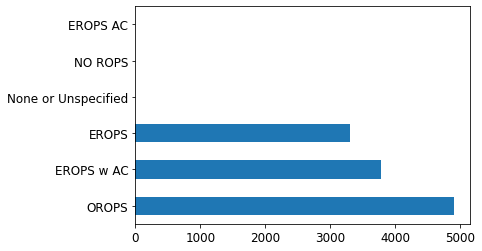

In [12]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis = 0)
x['pred'] = np.mean(preds, axis = 0)
x.Enclosure.value_counts().plot.barh()

In [13]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index = False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839607,0.269865
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.581777,0.263041
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.683254,0.222540


<AxesSubplot:ylabel='Enclosure'>

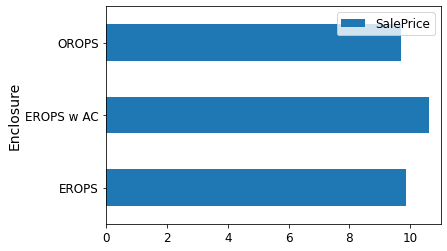

In [14]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim = (0, 11))

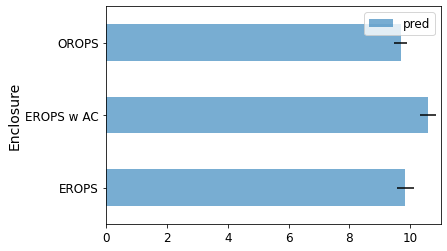

In [15]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

<AxesSubplot:>

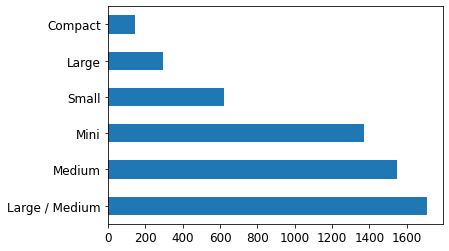

In [16]:
raw_valid.ProductSize.value_counts().plot.barh()

In [17]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.857148,0.336968
Large,10.470589,10.379691,0.354762
Large / Medium,10.691871,10.650442,0.294806
Medium,10.681511,10.628757,0.281810
Mini,9.535147,9.556309,0.239841
Small,10.324448,10.342899,0.307522


In [18]:
(summ.pred_std / summ.pred).sort_values(ascending = False)

ProductSize
Compact           0.034185
Large             0.034178
Small             0.029733
Large / Medium    0.027680
Medium            0.026514
Mini              0.025098
dtype: float64

## Feature importance

In [19]:
fi = rf_feat_importance(m, df_trn)
fi[:10]

,cols,imp
5,YearMade,0.174275
13,ProductSize,0.096908
14,fiProductClassDesc,0.090453
37,Coupler_System,0.086256
39,Hydraulics_Flow,0.077146
2,ModelID,0.055255
63,saleElapsed,0.050146
10,fiSecondaryDesc,0.041226
19,Enclosure,0.033894
38,Grouser_Tracks,0.033610


/home/skessler/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='cols'>

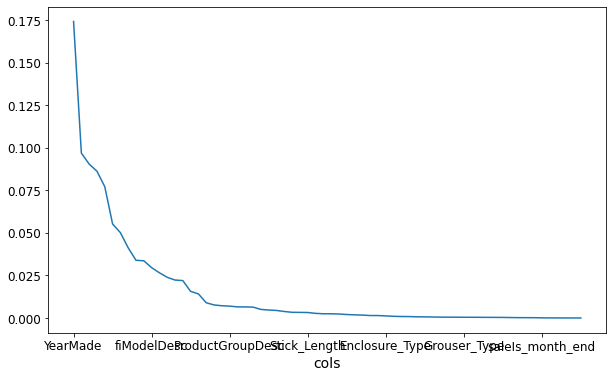

In [20]:
fi.plot('cols', 'imp', figsize = (10,6), legend = False)

In [21]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize = (12, 7), legend = False)

<AxesSubplot:ylabel='cols'>

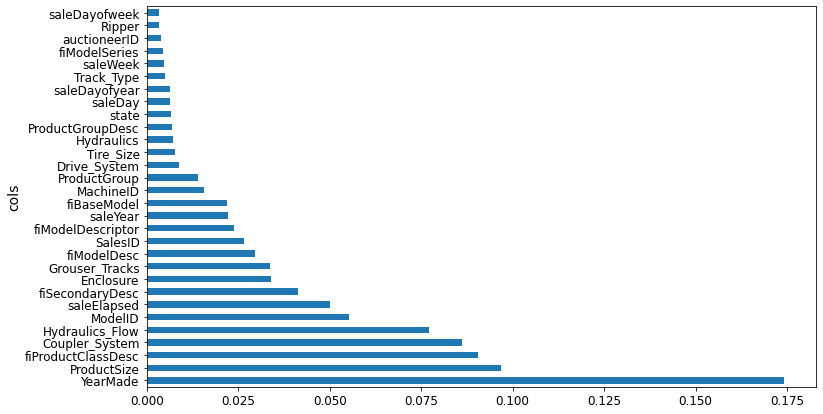

In [22]:
plot_fi(fi[:30])

In [23]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

25

In [24]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [25]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3,
                          max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.20686644877272795, 0.24520870797401995, 0.910563469311428, 0.8926209018796605, 0.8943462124544351]


<AxesSubplot:ylabel='cols'>

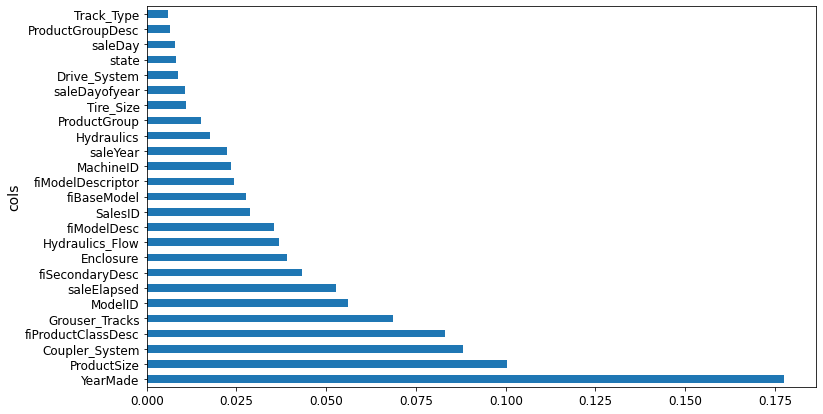

In [26]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

## One-hot encoding

In [27]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20732023304889896, 0.2513223691121466, 0.9101706612433128, 0.8871996975952005, 0.8924741550022293]


<AxesSubplot:ylabel='cols'>

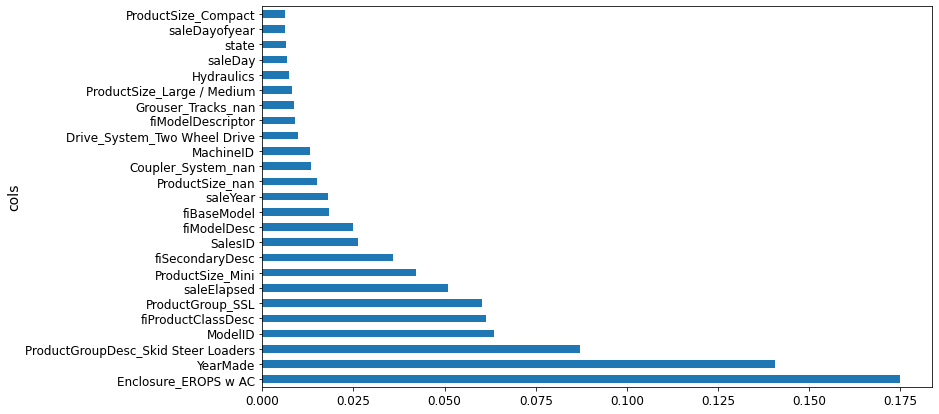

In [28]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25])

## Removing redundant features

In [29]:
from scipy.cluster import hierarchy as hc

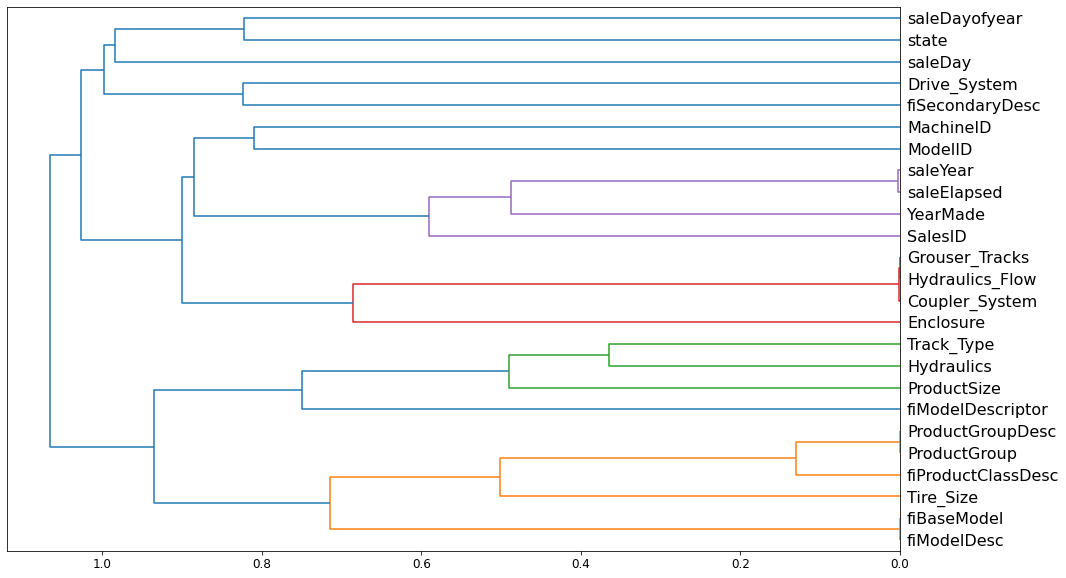

In [30]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method = 'average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = df_keep.columns, orientation = 'left', leaf_font_size = 16)
plt.show()

In [31]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators = 30, min_samples_leaf = 5, max_features = 0.6, n_jobs = -1, oob_score = True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [32]:
get_oob(df_keep)

0.8898305039818692

In [33]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis = 1)))

saleYear 0.8893600543205529
saleElapsed 0.8867939622893605
fiModelDesc 0.8894092651583739
fiBaseModel 0.889273371546295
Grouser_Tracks 0.8903771230896
Coupler_System 0.8896346765593273


In [34]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis = 1))

0.8886168594294522

In [35]:
df_keep.drop(to_drop, axis = 1, inplace = True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [36]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [37]:
keep_cols = np.load('tmp/keep_cols.npy', allow_pickle = True)
df_keep = df_trn[keep_cols]

In [38]:
reset_rf_samples()

In [39]:
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.12492876176560544, 0.22761620244527167, 0.9673818221003279, 0.9074760169105289, 0.9087357117135224]


## Partial Dependence

In [40]:
from pdpbox import pdp
from plotnine import *

In [41]:
set_rf_samples(50000)

In [42]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat = 7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.6, n_jobs = -1)
m.fit(X_train, y_train);

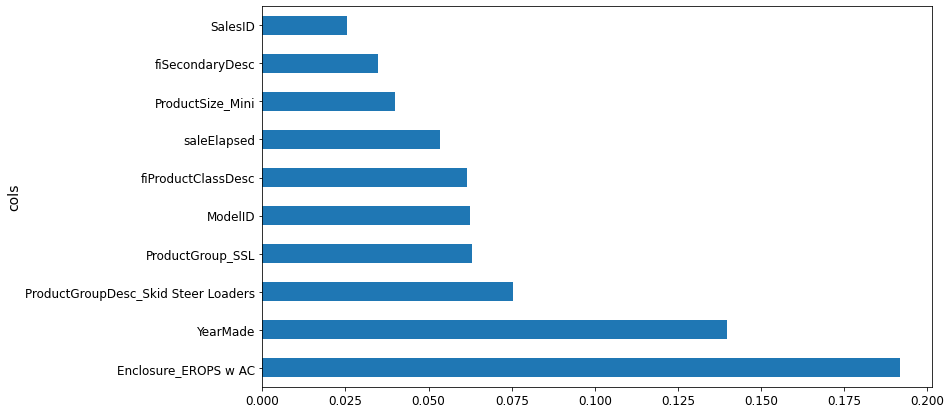

In [43]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

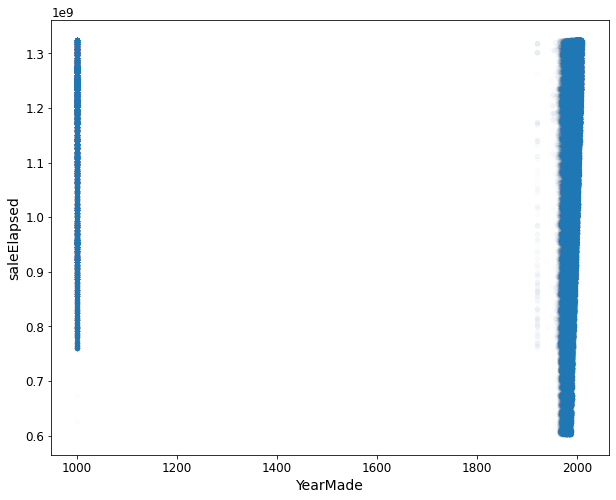

In [44]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha = 0.01, figsize=(10,8));

Apparently many bulldozers made in the year 1000 lol

In [45]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

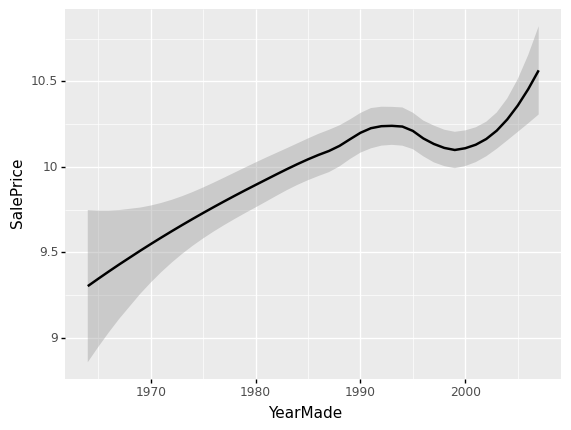

<ggplot: (8783963162498)>

In [46]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se = True, method = 'loess')

In [47]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [48]:
def plot_pdp(feat, clusters = None, feat_name = None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(model=m, dataset=x, model_features=x.columns, feature=feat)
    return pdp.pdp_plot(p, feat_name, plot_lines = True,
                        cluster = clusters is not None,
                        n_cluster_centers = clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='YearMade'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


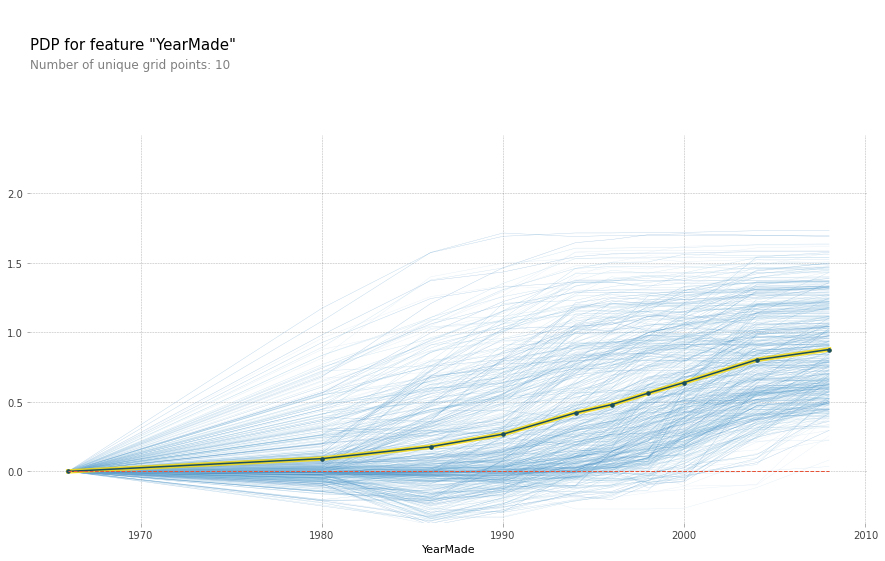

In [49]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='YearMade'>})

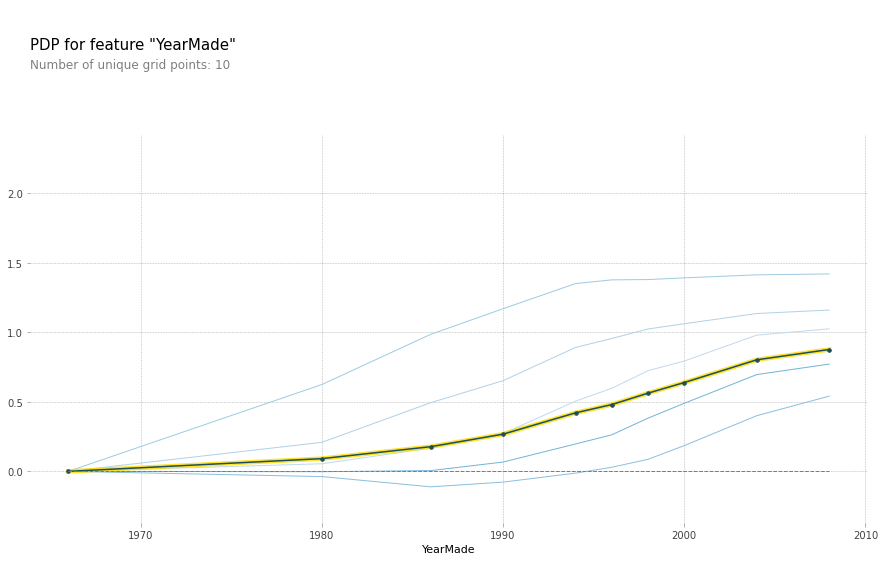

In [50]:
plot_pdp('YearMade', clusters = 5)

In [51]:
#feats = ['saleElapsed', 'YearMade']
#p = pdp.pdp_interact(model=m, dataset=x, model_features=x.columns, features=feats)
#pdp.pdp_interact_plot(p, feats)

In [52]:
#plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [53]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

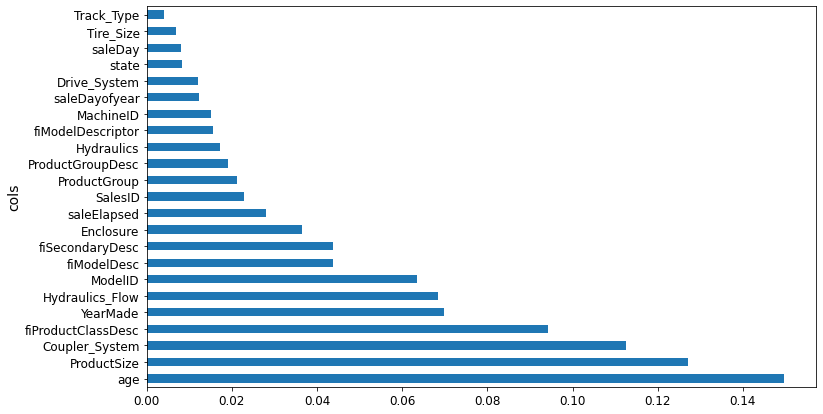

In [54]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.6, n_jobs = -1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

## Tree Interpreter

In [55]:
from treeinterpreter import treeinterpreter as ti

In [56]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [57]:
row = X_valid.values[None, 0]; row

array([[      1999,          5,         17,          0,          0,        665, 1284595200,          0,
                 1,       3232,    4364751,          0,    2300944,          4,          0,          0,
                12,          4,         35,         16,        259,          2,         11]])

In [58]:
prediction, bias, contributions = ti.predict(m, row)

In [59]:
prediction[0], bias[0]

(array([9.33768]), 10.10543686629254)

In [60]:
idxs = np.argsort(contributions[0])

In [61]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5221439796697056),
 ('age', 11, -0.1340382388790345),
 ('fiModelDesc', 'KX1212', -0.12348916323922828),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.12125731094533028),
 ('fiSecondaryDesc', nan, -0.062382683805506066),
 ('Enclosure', 'EROPS', -0.0452441244875776),
 ('SalesID', 4364751, -0.03675404243693401),
 ('fiModelDescriptor', nan, -0.025189399783069756),
 ('saleDayofyear', 259, -0.01016809869381392),
 ('Tire_Size', nan, -0.006688352082938253),
 ('saleElapsed', 1284595200, -0.0016048755093676537),
 ('saleDay', 16, 1.1142294064470094e-05),
 ('state', 'Ohio', 0.00016721864611040082),
 ('MachineID', 2300944, 0.005785631033781202),
 ('Hydraulics', 'Standard', 0.012475326888523552),
 ('Drive_System', nan, 0.012603316302334956),
 ('Track_Type', 'Steel', 0.013036936928687437),
 ('ProductGroupDesc', 'Track Excavators', 0.015022215309280319),
 ('ProductGroup', 'TEX', 0.023510007063410755),
 ('Hydraulics_Flow', nan, 0.03427

In [62]:
contributions[0].sum()

-0.767758952376143

## Extrapolation

In [63]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [64]:
m = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(x, y)
m.oob_score_

0.9999900280461202

In [65]:
fi = rf_feat_importance(m, x)
fi[:10]

,cols,imp
10,SalesID,0.814503
6,saleElapsed,0.129497
12,MachineID,0.044359
5,ModelID,0.002955
0,YearMade,0.002534
9,fiModelDesc,0.001302
8,Enclosure,0.001184
20,saleDayofyear,0.000795
16,Hydraulics,0.000746
7,fiSecondaryDesc,0.000650


In [66]:
feats = ['SalesID', 'saleElapsed', 'MachineID']

In [67]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [68]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [69]:
x.drop(feats, axis = 1, inplace = True)

In [71]:
m = RandomForestClassifier(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(x,y);
m.oob_score_

0.9790888127142412

In [72]:
fi = rf_feat_importance(m, x);
fi[:10]

,cols,imp
19,age,0.234277
0,YearMade,0.188993
17,saleDayofyear,0.157721
5,ModelID,0.076432
8,fiModelDesc,0.063772
16,saleDay,0.058878
15,state,0.052565
2,fiProductClassDesc,0.031879
6,fiSecondaryDesc,0.023253
7,Enclosure,0.021234


In [73]:
set_rf_samples(50000)

In [77]:
feats = ['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [78]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.2079121206512866, 0.24789633726373722, 0.9096570136535248, 0.8902541279030746, 0.8931569173377483]


In [79]:
for f in feats:
    df_subs = df_keep.drop(f, axis = 1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20873322201686864, 0.2444220546770126, 0.9089420266755797, 0.8933087618508261, 0.8927299392276004]
saleElapsed
[0.21374533672202897, 0.2533725872098075, 0.9045165454718397, 0.8853518038246583, 0.8874027280286795]
MachineID
[0.20676233911942993, 0.24615633343878074, 0.9106534680834142, 0.8917893507619813, 0.8948981636979184]
age
[0.20960023267784028, 0.24913493205898699, 0.9081840045873089, 0.889154714729076, 0.8914161529280703]
YearMade
[0.2086307514354889, 0.25044420494194686, 0.9090314084525948, 0.8879866082293341, 0.8924395291955675]
saleDayofyear
[0.20886014384269128, 0.2446035842830312, 0.9088312560195859, 0.8931502261531173, 0.8926613388266729]


In [80]:
reset_rf_samples()

In [81]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis = 1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 3, max_features = 0.5, n_jobs = -1, oob_score = True)
m.fit(X_train, y_train)
print_score(m)

[0.13759738173821828, 0.21840377629835728, 0.9604309916741366, 0.914813993230555, 0.9091763754720044]


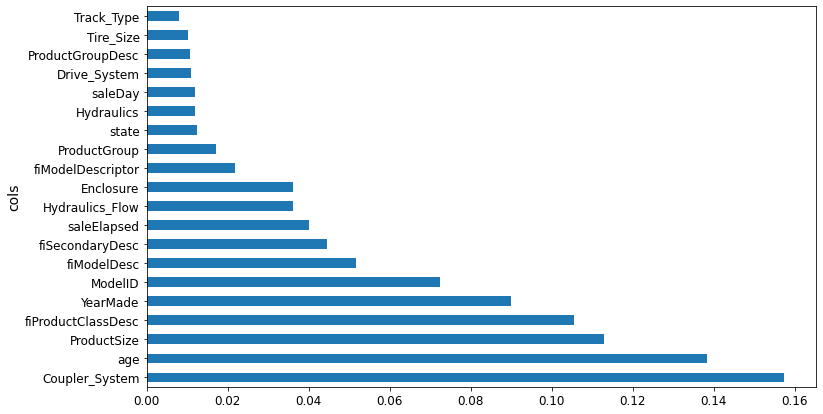

In [82]:
plot_fi(rf_feat_importance(m, X_train));

In [83]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

## Final Model

In [85]:
m = RandomForestRegressor(n_estimators = 160, max_features = 0.5, n_jobs = -1, oob_score = True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min 45s, sys: 2.01 s, total: 4min 47s
Wall time: 48.6 s
[0.08018135862544956, 0.21227570536129237, 0.9865636394926098, 0.9195273025235554, 0.9145102490170962]
